# Tutorial Week 9 - Bagging, Boosting and Random Forests

## Question 1 

#### We consider the forest canopy height data discussed in lectures from the spNNGP R package

https://cran.r-project.org/web/packages/spNNGP/index.html

#### A random subset of 5000 observations from the original data set will be used.  To get started you can import the following packages and functions.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import sklearn.model_selection as skm
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree)
from scipy.spatial import ConvexHull
from sklearn.ensemble import \
    (RandomForestRegressor as RF,
     GradientBoostingRegressor as GBR)

#### You can read in the data as follows.

In [28]:
BCEF = pd.read_csv('BCEF.csv',header=0,names=["Easting","Northing","FCH","PTC","holdout"])
BCEF.head()

,Easting,Northing,FCH,PTC,holdout
0,277.533541,1653.934914,12.53,76.000000,1
1,270.594000,1648.405211,7.05,77.353405,1
2,271.879366,1649.589274,11.64,46.062416,0
3,275.259678,1653.927843,9.80,43.476361,0
4,259.515725,1646.266058,15.49,81.627211,1


FCH is the response of interest (forest canopy height, in metres) and we will model FCH in terms of the Easting and Northing.

Extract features and response.

In [29]:
feature_names=list(BCEF.columns)
X=BCEF[['Easting','Northing']]
y=BCEF['FCH']

Train and plot the tree. We will just look at the tree without pruning, since this is what we use in bagging.

In [30]:
reg = DTR(min_samples_leaf=5)
reg.fit(X, y);

Plot the spatial trend for the fitted tree

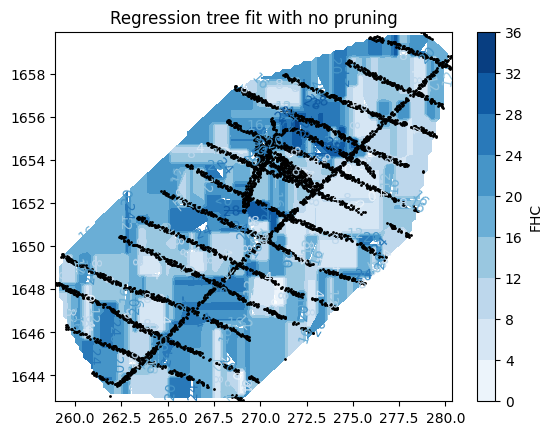

In [31]:
xp = np.linspace(X['Easting'].min(), X['Easting'].max(), 100)  
yp = np.linspace(X['Northing'].min(), X['Northing'].max(), 100)  
Xm, Ym = np.meshgrid(xp, yp) 
X_reshaped = Xm.flatten().reshape(-1, 1)  
Y_reshaped = Ym.flatten().reshape(-1, 1)  
features = np.concatenate((X_reshaped, Y_reshaped), axis=1)  
features = pd.DataFrame(features, columns=X.columns)
Z = reg.predict(features).reshape(Xm.shape)

subset_points = np.column_stack((np.array(X['Easting']),np.array(X['Northing'])))
hull = ConvexHull(subset_points)
mask = np.ones_like(Xm, dtype=bool)
for eq in hull.equations:
    mask &= (Xm * eq[0] + Ym * eq[1] + eq[2] <= 0)
X_masked = np.ma.masked_array(Xm, mask=~mask)
Y_masked = np.ma.masked_array(Ym, mask=~mask)
Z_masked = np.ma.masked_array(Z, mask=~mask)


fig, ax = plt.subplots()
levels = 8
cmap = "Blues"  # Specify the colormap name as a string
CS = ax.contourf(X_masked, Y_masked, Z_masked, levels, cmap=cmap)
ax.clabel(CS, inline=True, fontsize=10)
ax.plot(X['Easting'], X['Northing'], 'ko', markersize=1)
ax.set_title('Regression tree fit with no pruning')

# Add a colorbar

cbar = fig.colorbar(CS)
cbar.set_label('FHC')

#plt.savefig(fname="Lecture9-FCFig1.pdf")

Now let's repeat the above analysis using bagging with B=100

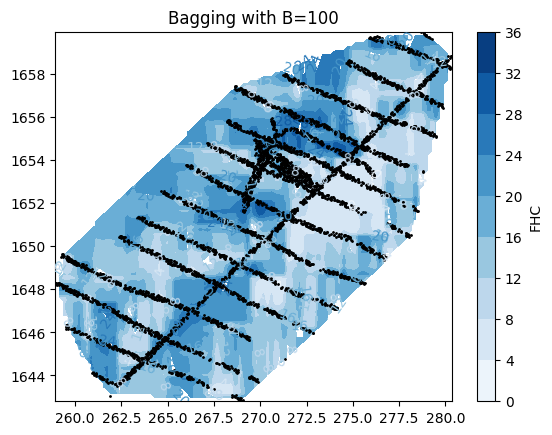

In [32]:
bag_BCEF = RF(max_features=X.shape[0], random_state=0)
bag_BCEF.fit(X,y)

Z = bag_BCEF.predict(features).reshape(Xm.shape)
Z_masked = np.ma.masked_array(Z, mask=~mask)

fig, ax = plt.subplots()
CS = ax.contourf(X_masked, Y_masked, Z_masked, levels, cmap=cmap)
ax.clabel(CS, inline=True, fontsize=10)
ax.plot(X['Easting'], X['Northing'], 'ko', markersize=1)
ax.set_title('Bagging with B=100')

# Add a colorbar
cbar = fig.colorbar(CS)
cbar.set_label('FHC')

# Save figure
#plt.savefig(fname="Lecture9-FCFig2.pdf")

Now we consider boosting, with max_depth=1 first (an additive model) and then max_depth=2 (second order interactions).

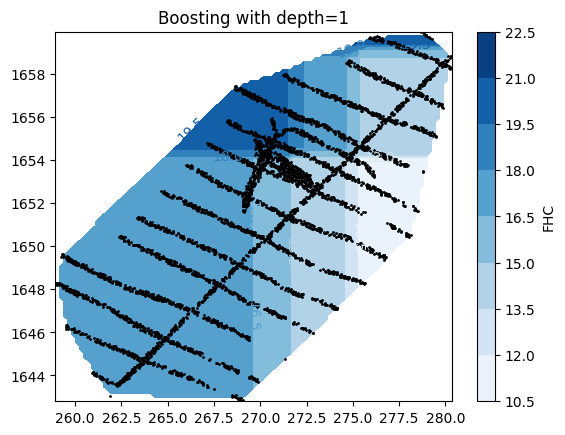

In [33]:
boost_BCEF = GBR(n_estimators=5000,
                learning_rate=0.001,
                max_depth=1,
                random_state=0)
boost_BCEF.fit(X,y)

Z = boost_BCEF.predict(features).reshape(Xm.shape)
Z_masked = np.ma.masked_array(Z, mask=~mask)

fig, ax = plt.subplots()
CS = ax.contourf(X_masked, Y_masked, Z_masked, levels, cmap=cmap)
ax.clabel(CS, inline=True, fontsize=10)
ax.plot(X['Easting'], X['Northing'], 'ko', markersize=1)
ax.set_title('Boosting with depth=1')

cbar = fig.colorbar(CS)
cbar.set_label('FHC')

#plt.savefig(fname="Lecture9-FCFig3.pdf")

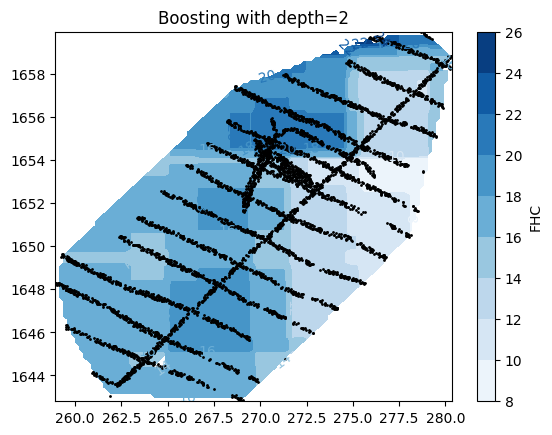

In [34]:
boost_BCEF = GBR(n_estimators=5000,
                learning_rate=0.001,
                max_depth=2,
                random_state=0)
boost_BCEF.fit(X,y)

Z = boost_BCEF.predict(features).reshape(Xm.shape)
Z_masked = np.ma.masked_array(Z, mask=~mask)

fig, ax = plt.subplots()
CS = ax.contourf(X_masked, Y_masked, Z_masked, levels, cmap=cmap)
ax.clabel(CS, inline=True, fontsize=10)
ax.plot(X['Easting'], X['Northing'], 'ko', markersize=1)
ax.set_title('Boosting with depth=2')

cbar = fig.colorbar(CS)
cbar.set_label('FHC')

#plt.savefig(fname="Lecture9-FCFig4.pdf")

## Question 2

#### We consider once again the Singlish example from last lecture.  We will see if we can improve on a classification tree using bagging, random forests and gradient boosting.  To start we do the following imports.

In [35]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR,
      RandomForestClassifier as RFC,
      GradientBoostingClassifier as GBC)

#### Read in Singlish data to a pandas data frame

In [36]:
Singlish = pd.read_csv('Singlish.csv')
Singlish.head()

,a,e,h,s,g,l,m,label,phrase
0,0.142857,0.0,0.0,0.0,0.00,0.142857,0.000000,S,Act blur
1,0.500000,0.0,0.0,0.0,0.25,0.000000,0.000000,S,Agak agak
2,0.200000,0.0,0.2,0.0,0.00,0.000000,0.000000,S,Aiyoh
3,0.500000,0.0,0.0,0.0,0.00,0.166667,0.166667,S,Alamak
4,0.200000,0.0,0.0,0.0,0.00,0.000000,0.000000,S,Arrow


 Extract features and response.

In [37]:
feature_names=list(Singlish.columns)[:7]
X=Singlish[feature_names]
y=Singlish['label']
X.head()

,a,e,h,s,g,l,m
0,0.142857,0.0,0.0,0.0,0.00,0.142857,0.000000
1,0.500000,0.0,0.0,0.0,0.25,0.000000,0.000000
2,0.200000,0.0,0.2,0.0,0.00,0.000000,0.000000
3,0.500000,0.0,0.0,0.0,0.00,0.166667,0.166667
4,0.200000,0.0,0.0,0.0,0.00,0.000000,0.000000


Split into training and test data, and grow a large tree on the training data.

In [38]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                y,
                                test_size=0.5,
                                random_state=0)

Train and plot the tree

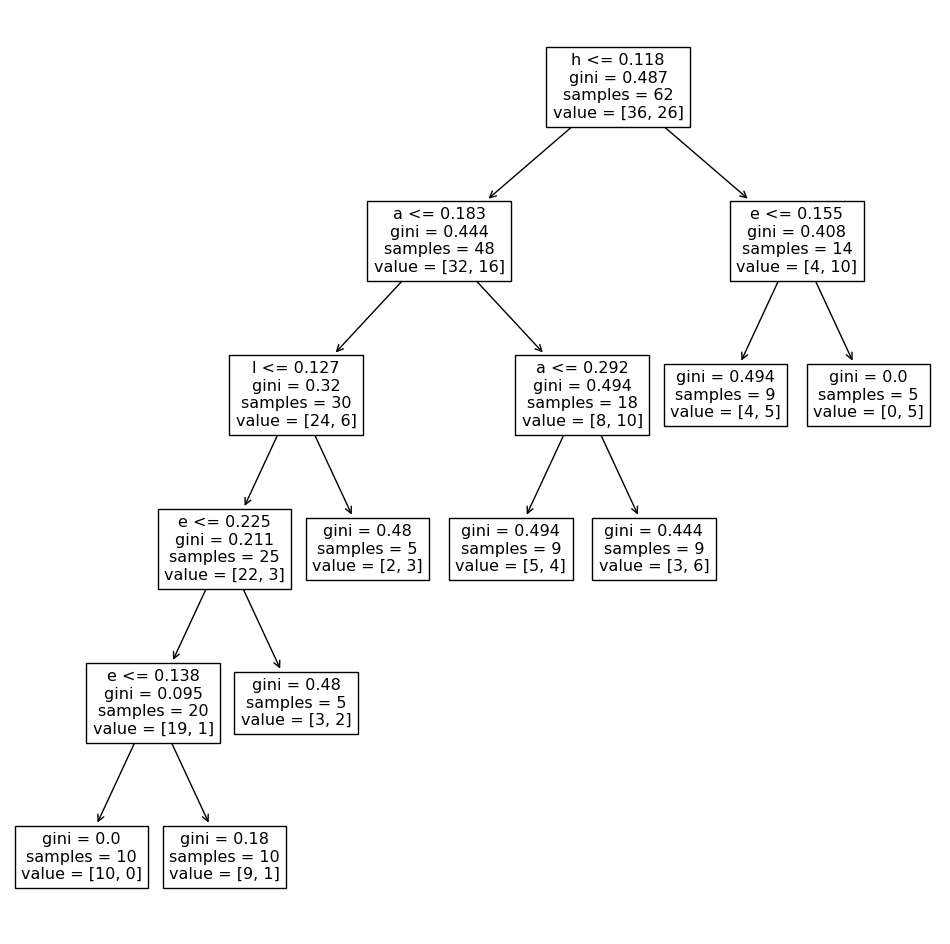

In [39]:
clf = DTC(min_samples_leaf=5)
clf.fit(X_train, y_train)
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);

Select the best value of  for cost-complexity pruning based on 5-fold cross-validation with the training data.

In [40]:
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10,
                  shuffle=True,
                  random_state=0)
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
G = grid.fit(X_train, y_train)

For the optimal choice of  and fitted tree to the training data, evaluate the performance on the test data.

In [41]:
best_ = grid.best_estimator_
accuracy_score(y_test,best_.predict(X_test))

0.6451612903225806

## Bagging

Let's try bagging with trees, using the default implementation from RandomForestClassifier

In [42]:
bag_Singlish = RFC(max_features=X.shape[1], random_state=0)
bag_Singlish.fit(X_train,y_train)
accuracy_score(y_test,bag_Singlish.predict(X_test))

0.5483870967741935

The default form of bagging performs worse than classification trees here.  Next look at feature importance.

## Random forests

In [43]:
RFC_Singlish = RFC(max_features=3, random_state=0)
RFC_Singlish.fit(X_train,y_train)
accuracy_score(y_test,RFC_Singlish.predict(X_test))

0.5483870967741935

In [44]:
RFC_Singlish = RFC(max_features=2, random_state=0)
RFC_Singlish.fit(X_train,y_train)
accuracy_score(y_test,RFC_Singlish.predict(X_test))

0.5645161290322581

## Boosting

Next we try a gradient boosting classifier, with $\lambda=0.001$, using "stumps" (i.e. ``max_depth=1``)

In [45]:
boost_Singlish = GBC(n_estimators=5000,
                     learning_rate=0.001,
                     max_depth = 1,
                     random_state = 0
                    )
boost_Singlish.fit(X_train,y_train)
accuracy_score(y_test,boost_Singlish.predict(X_test))

0.5967741935483871

Try $\lambda=0.01$

In [46]:
boost_Singlish = GBC(n_estimators=5000,
                     learning_rate=0.01,
                     max_depth = 1,
                     random_state = 0
                    )
boost_Singlish.fit(X_train,y_train)
accuracy_score(y_test,boost_Singlish.predict(X_test))

0.5806451612903226

Try $\lambda=0.001$ and allow second-order interactions, ``max_depth=2``

In [47]:
boost_Singlish = GBC(n_estimators=5000,
                     learning_rate=0.001,
                     max_depth = 2,
                     random_state = 0
                    )
boost_Singlish.fit(X_train,y_train)
accuracy_score(y_test,boost_Singlish.predict(X_test))

0.5967741935483871

Let's look at the test error (log-loss) versus boosting iteration to see if we are overfitting.

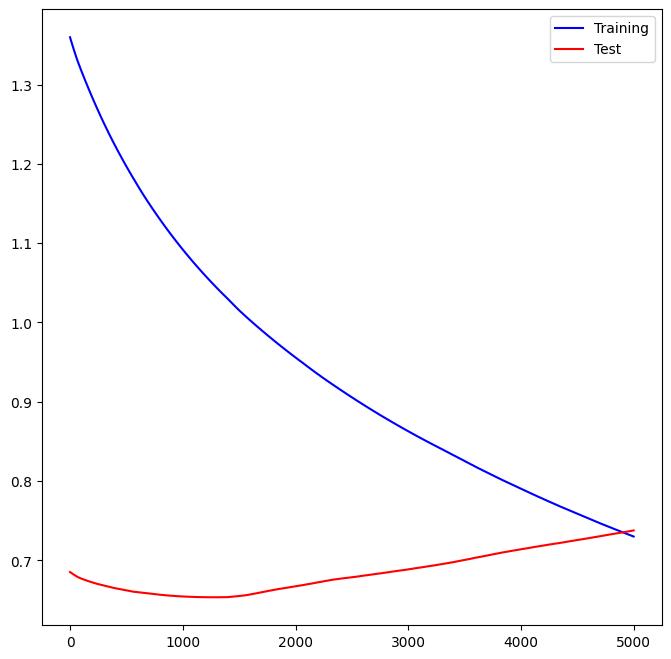

In [48]:
test_error = np.zeros_like(boost_Singlish.train_score_)
for idx, y_ in enumerate(boost_Singlish.staged_predict_proba(X_test)):
   test_error[idx] = log_loss(y_test,y_)

plot_idx = np.arange(boost_Singlish.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_Singlish.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

In [49]:
boost_Singlish = GBC(n_estimators=1500,
                     learning_rate=0.001,
                     max_depth = 2,
                     random_state = 0
                    )
boost_Singlish.fit(X_train,y_train)
accuracy_score(y_test,boost_Singlish.predict(X_test))

0.6129032258064516